##  Reconstruction Of Images Using RBM on MNIST dataset

* Import the modules

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

* Declare the class RBM. The __init__ function will build the complete graph, forward and backward pass, and the objective function. 
* We use the TensorFlow built-in optimizer to update the weights and biases

In [2]:

class RBM(object):
    def __init__(self, visible, hidden):
        """
        visible: Number of neurons in visible layer
        hidden: number of neurons in hidden layer
        """
        self._visible = visible
        self._hidden = hidden
                
        
        
        # Create the Computational graph
       
        # Weights and biases
        self._W = tf.Variable(tf.random_normal(shape=(self._visible,self._hidden)))
        self._hidden_bias = tf.Variable(np.zeros(self._hidden).astype(np.float32))  #bias for hidden layer
        self._visible_bias = tf.Variable(np.zeros(self._visible).astype(np.float32))  #bias for Visible layer
            
        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._visible])
                                               
        # Forwards Pass
        _h = tf.nn.sigmoid(tf.matmul(self._X, self._W) + self._hidden_bias)
        self.h = tf.nn.relu(tf.sign(_h - tf.random_uniform(tf.shape(_h))))
                      
            
        #Backward pass
        _v = tf.nn.sigmoid(tf.matmul(self.h, tf.transpose(self._W)) + self._visible_bias)
        self.V = tf.nn.relu(tf.sign(_v - tf.random_uniform(tf.shape(_v))))
                        
                                              
        # Objective Function
        objective = tf.reduce_mean(self.free_energy(self._X)) - tf.reduce_mean(
                              self.free_energy(self.V))
        self._train_op =  tf.train.GradientDescentOptimizer(1e-3).minimize(objective)
        
        # Cross entropy cost
        reconstructed_input = self.one_pass(self._X)
        self.cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
                labels=self._X, logits=reconstructed_input))

            
            
    def set_session(self, session):
        self.session = session
            
                                   
            
    def free_energy(self, V):
        b = tf.reshape(self._visible_bias, (self._visible, 1))
        term_1 = -tf.matmul(V,b)
        term_1 = tf.reshape(term_1, (-1,))
        
        term_2 = -tf.reduce_sum(tf.nn.softplus(tf.matmul(V,self._W) + self._hidden_bias))
        return term_1 + term_2
    
    def one_pass(self, X):
        h = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return tf.matmul(h, tf.transpose(self._W)) + self._visible_bias
    
    def reconstruct(self,X):
        x = tf.nn.sigmoid(self.one_pass(X))
        return self.session.run(x, feed_dict={self._X: X})
     
    def rbm_output(self,X):
        x = tf.nn.sigmoid(tf.matmul(X, self._W) + self._hidden_bias)
        return self.session.run(x, feed_dict={self._X: X})
        
        
    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size
        
        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._train_op,self.cost ], feed_dict={self._X: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost {1}'.format((i+1),ob, j)) 
                obj.append(ob)
        return obj

* Load the MNIST dataset

In [3]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
train_X, train_Y, test_X, test_Y = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


* We train our RBM on the MNIST dataset

In [4]:
X_train = train_X.astype(np.float32)
X_test = test_X.astype(np.float32)
_, m = X_train.shape
rbm = RBM(m, 100)
#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    rbm.set_session(sess)
    err = rbm.fit(X_train, epochs=3)
    out = rbm.reconstruct(X_test[0:100])  # Let us reconstruct Test Data

training epoch 1 batch 0 cost 2.601088285446167
training epoch 1 batch 100 cost 0.2947143018245697
training epoch 1 batch 200 cost 0.2703692317008972
training epoch 1 batch 300 cost 0.26889219880104065
training epoch 1 batch 400 cost 0.2515017092227936
training epoch 1 batch 500 cost 0.25660964846611023
training epoch 2 batch 0 cost 0.25032269954681396
training epoch 2 batch 100 cost 0.229159414768219
training epoch 2 batch 200 cost 0.21945390105247498
training epoch 2 batch 300 cost 0.22956086695194244
training epoch 2 batch 400 cost 0.22161854803562164
training epoch 2 batch 500 cost 0.22630485892295837
training epoch 3 batch 0 cost 0.22141459584236145
training epoch 3 batch 100 cost 0.20926757156848907
training epoch 3 batch 200 cost 0.20339013636112213
training epoch 3 batch 300 cost 0.21075324714183807
training epoch 3 batch 400 cost 0.2069055289030075
training epoch 3 batch 500 cost 0.2133961021900177


Text(0, 0.5, 'cost')

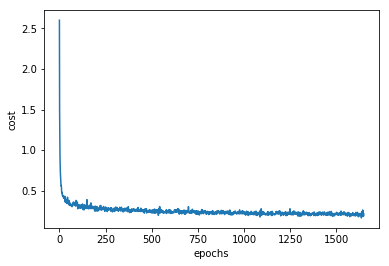

In [5]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('cost')

* We can see the original and reconstructed MNIST images by using a small helper plotting code

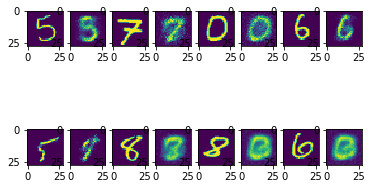

In [6]:
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col)

j, k = 0,0
for i in idx:
    axarr[j,k].imshow(X_test[i].reshape(28,28))
    axarr[j,k+1].imshow(out[i].reshape(28,28))
    k = k+2
    if k==col:
        j,k=1, 0